***
*Project:* The Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 3</span> 

# Modern Helmholtz Machine

*Created:* April 13, 2025

The modified Helmholtz machine structure is given below:

<img src="Modern.jpg" style="width:800px">
<caption><center> **Figure 1**: Modern Helmholtz Machine. Blue neurons represent instantiation layers, where the neurons take binary values. Orange neurons indicate the inserted activations, where the neurons take value in real numbers in given range.    </center></caption>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of shape (n_mlp_max, n_smp). n_mlp_max is the maximum number of MLP layers. 
            n_smp is the number of sampled layers
    dev -- torch device

    Returns:
    Phi, Theta -- set of parameters (random initialization) for hierarchical layers. len(Phi) = n_smp-2. len(Theta) = n_smp-1.
    """
    Phi = {}
    Theta = {}
    n_smp = n_dz.shape[1]
    for i in range(n_smp-2):
        n_mlp = len(torch.where(n_dz[:,i] != 0)[0])
        Phi["Phi_" + str(i) + str(i+1)] = {}
        for j in range(n_mlp-1):
            Phi["Phi_" + str(i) + str(i+1)][j] = torch.rand(n_dz[j+1,i],n_dz[j,i],device=dev)
        Phi["Phi_" + str(i) + str(i+1)][n_mlp-1] = torch.rand(n_dz[0,i+1],n_dz[n_mlp-1,i],device=dev)
    for i in range(n_smp-1,0,-1):
        n_mlp = len(torch.where(n_dz[:,i-1] != 0)[0])
        Theta["Theta_" + str(i) + str(i-1)] = {}
        Theta["Theta_" + str(i) + str(i-1)][0] = torch.rand(n_dz[n_mlp-1,i-1],n_dz[0,i],device=dev)
        for j in range(n_mlp-1):
            Theta["Theta_" + str(i) + str(i-1)][j+1] = torch.rand(n_dz[n_mlp-j-2,i-1],n_dz[n_mlp-j-1,i-1],device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def layer_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    
    Returns:
    q -- probability of sample layer y, torch tensor of shape (n_y,batch_size)
    """
    n_mlp = len(param)
    q = x
    for i in range(n_mlp):
        q = one_step_forward(q,param[i])
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    param -- updated parameters from x to y.
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    Q -- the activations of each layer. Bernoulli probabilities. Python dictionary of length n_mlp, of keys 0,1,2,...
    """
    batch_size = x.shape[1]
    n_mlp = len(param)
    Q = {}    # activation/ probability
    q = x
    for i in range(n_mlp):
        Q[i] = one_step_forward(q,param[i])
        q = Q[i]
    u = Q[n_mlp-1] - y # (n_y,batch_size)
    loss = cross_entropy_loss(y,Q[n_mlp-1])
    for i in range(n_mlp-1,0,-1):
        dW = torch.matmul(u,torch.t(Q[i-1]))/batch_size
        dz = torch.matmul(torch.t(param[i]),u) # (n_z,batch_size)
        param[i] -= lr*dW
        u = dz * Q[i-1] * (1-Q[i-1])
    dW_x = torch.matmul(u,torch.t(x.type(torch.float)))/batch_size
    param[0] -= lr*dW_x
    return param, loss, Q

In [10]:
def wake_phase_fixed(Phi,fixed_sample,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length n_layer-1.
                    Each element is a torch tensor of shape (n_dz[0,i],batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated wake phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    for i in range(n_layer-2):
        Phi["Phi_" + str(i) + str(i+1)], Loss[i+1], Q = \
        one_step_update(fixed_sample['Layer_'+str(i)],fixed_sample['Layer_'+str(i+1)],Phi["Phi_" + str(i) + str(i+1)],lr)
    return Phi, Loss

In [11]:
def sleep_phase_fixed(Theta,fixed_sample,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length n_layer-1.
                    Each element is a torch tensor of shape (n_dz[0,i],batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    fixed_sample['Layer_'+str(n_layer-1)] = torch.ones(1,batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)], Loss[i-1], Q = \
        one_step_update(fixed_sample['Layer_'+str(i)],fixed_sample['Layer_'+str(i-1)],Theta["Theta_" + str(i) + str(i-1)],lr)
    return Theta, Loss

In [12]:
def wake_sample_HM(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [13]:
def sleep_sample_HM(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [14]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    H_YX -- conditional entropy from layer X to Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    return H_Y, H_YX

In [15]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    H_Y_wake = torch.zeros(n_layer-2)
    H_YX_wake = torch.zeros(n_layer-2)
    for i in range(n_layer-2):
        q = layer_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], H_YX_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample, H_Y_wake, H_YX_wake

In [16]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    H_Y_sleep = torch.zeros(n_layer-1)
    H_YX_sleep = torch.zeros(n_layer-1)
    for i in range(n_layer-1,0,-1):
        q = layer_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], H_YX_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample, H_Y_sleep, H_YX_sleep

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [20]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [21]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [22]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [23]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [24]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    
    # Compute output layer distribution
    q = layer_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, loss

In [25]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [26]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

## Mutual Information Maximization
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [27]:
def one_step_update_nocover(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    param -- updated parameters from x to y.
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    Q -- the activations of each layer. Bernoulli probabilities. Python dictionary of length n_mlp, of keys 0,1,2,...
    """
    batch_size = x.shape[1]
    n_mlp = len(param)
    Q = {}    # activation/ probability
    q = x
    param_update = param.copy()
    for i in range(n_mlp):
        Q[i] = one_step_forward(q,param[i])
        q = Q[i]
    u = Q[n_mlp-1] - y # (n_y,batch_size)
    loss = cross_entropy_loss(y,Q[n_mlp-1])
    for i in range(n_mlp-1,0,-1):
        dW = torch.matmul(u,torch.t(Q[i-1]))/batch_size
        dz = torch.matmul(torch.t(param[i]),u) # (n_z,batch_size)
        param_update[i] = param[i] - lr*dW
        u = dz * Q[i-1] * (1-Q[i-1])
    dW_x = torch.matmul(u,torch.t(x.type(torch.float)))/batch_size
    param_update[0] = param[0] - lr*dW_x
    return param_update, loss, Q

In [28]:
def increment(input_x, param, lr, dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    # Compute output layer distribution
    q = layer_step_forward(input_x,param)
    
    # Sample the output layer
    output_y = (torch.rand(q.shape[0],q.shape[1],device=dev) > 0.5).long()
    
    # Update parameter based on the sampled y
    param_update, loss, Q = one_step_update_nocover(input_x,output_y,param,lr)
    
    # Updated output layer distribution
    q_plus1 = layer_step_forward(input_x,param_update)
    
    eps = (q - q_plus1)/(q - output_y + 1e-8) # (n_y,batch_size)
#     print(eps)
    eps = eps.mean().abs()
    return eps

In [29]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample,H,h = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
    return Epsilon

In [30]:
def initialize_MI_sleep(Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    Gen_sample,H,h = sleep_sample(Theta,gen_batch_size,dev)
    for i in range(n_layer-3,-1,-1):
        input_x = Gen_sample["Layer_" + str(i+1)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Theta["Theta_" + str(i+1) + str(i)], lr,dev)
    return Epsilon

In [31]:
def MI_sample_single(input_x,index,param,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_yx = q[:,index] # (n_y,)
    q_sample = (q_yx > 0.5).long()
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    if temp == False:
        mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
    else:
        mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    output_y[:,index] = y_sample
    
    return output_y

In [32]:
def MI_sample_single_comp(input_x,index,param,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    output_y = sample(q,dev) # (n_y,batch_size)
    p_y = q.mean(axis=1) # (n_y,)
    n_y = len(p_y)
    
    q_yx_0 = q[0,index]
    if (q_yx_0 - 0.5).abs() > (p_y[0] - 0.5).abs():
        output_y[0,index] = (q_yx_0 > 0.5).long()
    else:
        output_y[0,index] = (p_y[0] < 0.5).long()
    
    for i in range(1,n_y):
        q_yx_i = q[i,index]
        p_y_i = p_y[i]
        k = 1
        ind0 = torch.where(output_y[:i,index] == 0)[0]
        ind1 = torch.where(output_y[:i,index] == 1)[0]
        if len(ind0) != 0:
            ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
            if len(ind_choice) > 1:
                p_y_0 = q[i,ind_choice[ind_choice != index]].mean()
                p_y_i = p_y_i + p_y_0
                k += 1
        if len(ind1) != 0:
            ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
            if len(ind_choice) > 1:
                p_y_1 = q[i,ind_choice[ind_choice != index]].mean()
                p_y_i = p_y_i + p_y_1
                k += 1
        p_y_i = p_y_i/k
        
        if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
            output_y[i,index] = (q_yx_i > 0.5).long()
        else:
            output_y[i,index] = (p_y_i < 0.5).long()
        
#     if temp == False:
#         mask = ((q_yx - 0.5).abs() > (p_y - 0.5).abs()).long()
#     else:
#         mask = ((q_yx - 0.5).abs()*(1-(p_y - 0.5).abs()*2) > (p_y - 0.5).abs()).long()
    
    return output_y

In [33]:
def MI_sample_batch(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1,keepdim=True) # (n_y,1)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    mask = ((q - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    
    output_y = y_sample
#     output_y[:,int(batch_size/2)] = y_sample[:,int(batch_size/2)]
    
    return output_y

In [34]:
def MI_sample_batch_acc(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for i in range(batch_size):
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
        p_y = (1-eps)*p_y + eps*y_sample
    
    return output_y

In [35]:
def MI_sample_batch_acc_comp(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    n_y = len(p_y)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for j in range(batch_size):
        q_yx_0 = q[0,j]
        p_y_0 = p_y[0]
        if (q_yx_0 - 0.5).abs() > (p_y_0 - 0.5).abs():
            output_y[0,j] = (q_yx_0 > 0.5).long()
        else:
            output_y[0,j] = (p_y_0 < 0.5).long()
        
        for i in range(1,n_y):
            q_yx_i = q[i,j]
            p_y_i = p_y[i]
            k = 1
            ind0 = torch.where(output_y[:i,j] == 0)[0]
            ind1 = torch.where(output_y[:i,j] == 1)[0]
            if len(ind0) != 0:
                ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
                if len(ind_choice) > 1:
                    p_y_0 = q[i,ind_choice[ind_choice != j]].mean()
                    p_y_i = p_y_i + p_y_0
                    k += 1
            if len(ind1) != 0:
                ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
                if len(ind_choice) > 1:
                    p_y_1 = q[i,ind_choice[ind_choice != j]].mean()
                    p_y_i = p_y_i + p_y_1
                    k += 1
            p_y_i = p_y_i/k

            if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
                output_y[i,j] = (q_yx_i > 0.5).long()
            else:
                output_y[i,j] = (p_y_i < 0.5).long()

        p_y = (1-eps)*p_y + eps*output_y[:,j]

    return output_y

In [36]:
def MI_train_batch(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_batch_acc(input_x,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [37]:
def wake_phase_MI_batch(Phi,Theta,data,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [38]:
def sleep_phase_MI_batch(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

In [39]:
def MI_train_single(input_x,index,param_xy,param_yx,lr,dev,temp):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_single(input_x,index,param_xy,dev,temp)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y[:,index:index+1],input_x[:,index:index+1],param_yx,lr)

    return output_y, param_yx, loss

In [40]:
def wake_phase_MI_single(Phi,Theta,data,index,lr,dev,temp):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    lr -- learning rate
    dev -- torch device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_single(input_x,index,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,dev,temp)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,1,dtype=int,device=dev),input_x[:,index:index+1],Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [41]:
def sleep_phase_MI_single(Phi,Theta,gen_batch_size,lr,dev,temp):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    dev -- torch device
    temp -- with teparature or not. Boolean value True or False.
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = MI_sample_single(unit,0,Theta["Theta_"+ str(n_layer-1) + str(n_layer-2)],dev,temp)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_single(input_x,0,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,dev,temp)
        input_x = output_y
    return Phi, Loss

In [42]:
def MI_deterministic(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    
    for i in range(n_y):
        q0 = q[i,:] # (batch_size,)
        values,indices = (q0-0.5).abs().sort()
        Sum = output_y[i,:].sum()
        for j in range(batch_size):
            p_y = Sum/batch_size
            p_sample = (p_y < 0.5).long()
            if values[j] < (p_y - 0.5).abs() and output_y[i,indices[j]] != p_sample:
                output_y[i,indices[j]] = p_sample
                Sum = Sum + 2*p_sample-1
            elif values[j] > (p_y - 0.5).abs():
                break
    return output_y

In [43]:
def wake_sample_deterministic(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = MI_deterministic(input_x,Phi["Phi_" + str(i) + str(i+1)],dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [58]:
def MI_deterministic_MHM(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    
    for i in range(n_y):
        q0 = q[i,:] # (batch_size,)
        values,indices = (q0-0.5).abs().sort()
        Sum = output_y[i,:].sum()
        for j in range(batch_size):
            p_y = Sum/batch_size
            p_sample = (p_y < 0.5).long()
            if values[j] < (p_y - 0.5).abs() and output_y[i,indices[j]] != p_sample:
                output_y[i,indices[j]] = p_sample
                Sum = Sum + 2*p_sample-1
            elif values[j] > (p_y - 0.5).abs():
                break
    return output_y

In [59]:
def wake_sample_deterministic_MHM(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = MI_deterministic_MHM(input_x,Phi["Phi_" + str(i) + str(i+1)],dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

## Model

In [46]:
dev = torch.device('cuda')

In [172]:
structure = np.array([[12,9,6,3,1],
             [11, 8,5,2,0]])
n_dz = torch.tensor(structure)
n_dz

tensor([[12,  9,  6,  3,  1],
        [11,  8,  5,  2,  0]], dtype=torch.int32)

In [173]:
n_mlp_max = n_dz.shape[0]
n_layer = n_dz.shape[1]
n_d = n_dz[0,0]

In [49]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [50]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [51]:
Phi,Theta = para_init(n_dz,dev)

In [52]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [53]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [54]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [55]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
# col_list.append('Accuracy')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Data_D_KL',
 'Gen_D_KL',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3']

In [56]:
len(col_list)

22

## Scheduling

In [70]:
Analytic_MHM_layer2 = pd.DataFrame(columns=col_list)
Analytic_MHM_layer2

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Recog_H_Layer_1,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3


In [274]:
# Analytic_MHM_layer1 = pd.read_csv('Analytic_MHM_layer1.csv', sep=",")
# Analytic_MHM_layer1

In [186]:
para = torch.load('Parameters_MHM_layer1_2', dev,weights_only=True)
Phi_HM = para['Phi']
Theta_HM = para['Theta']

In [187]:
Phi,Theta = para_init(n_dz,dev)

In [201]:
para = torch.load('Parameters_MHM_layer1_2', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [189]:
scheduled_sample = wake_sample_deterministic_MHM(Phi_HM,data,dev)

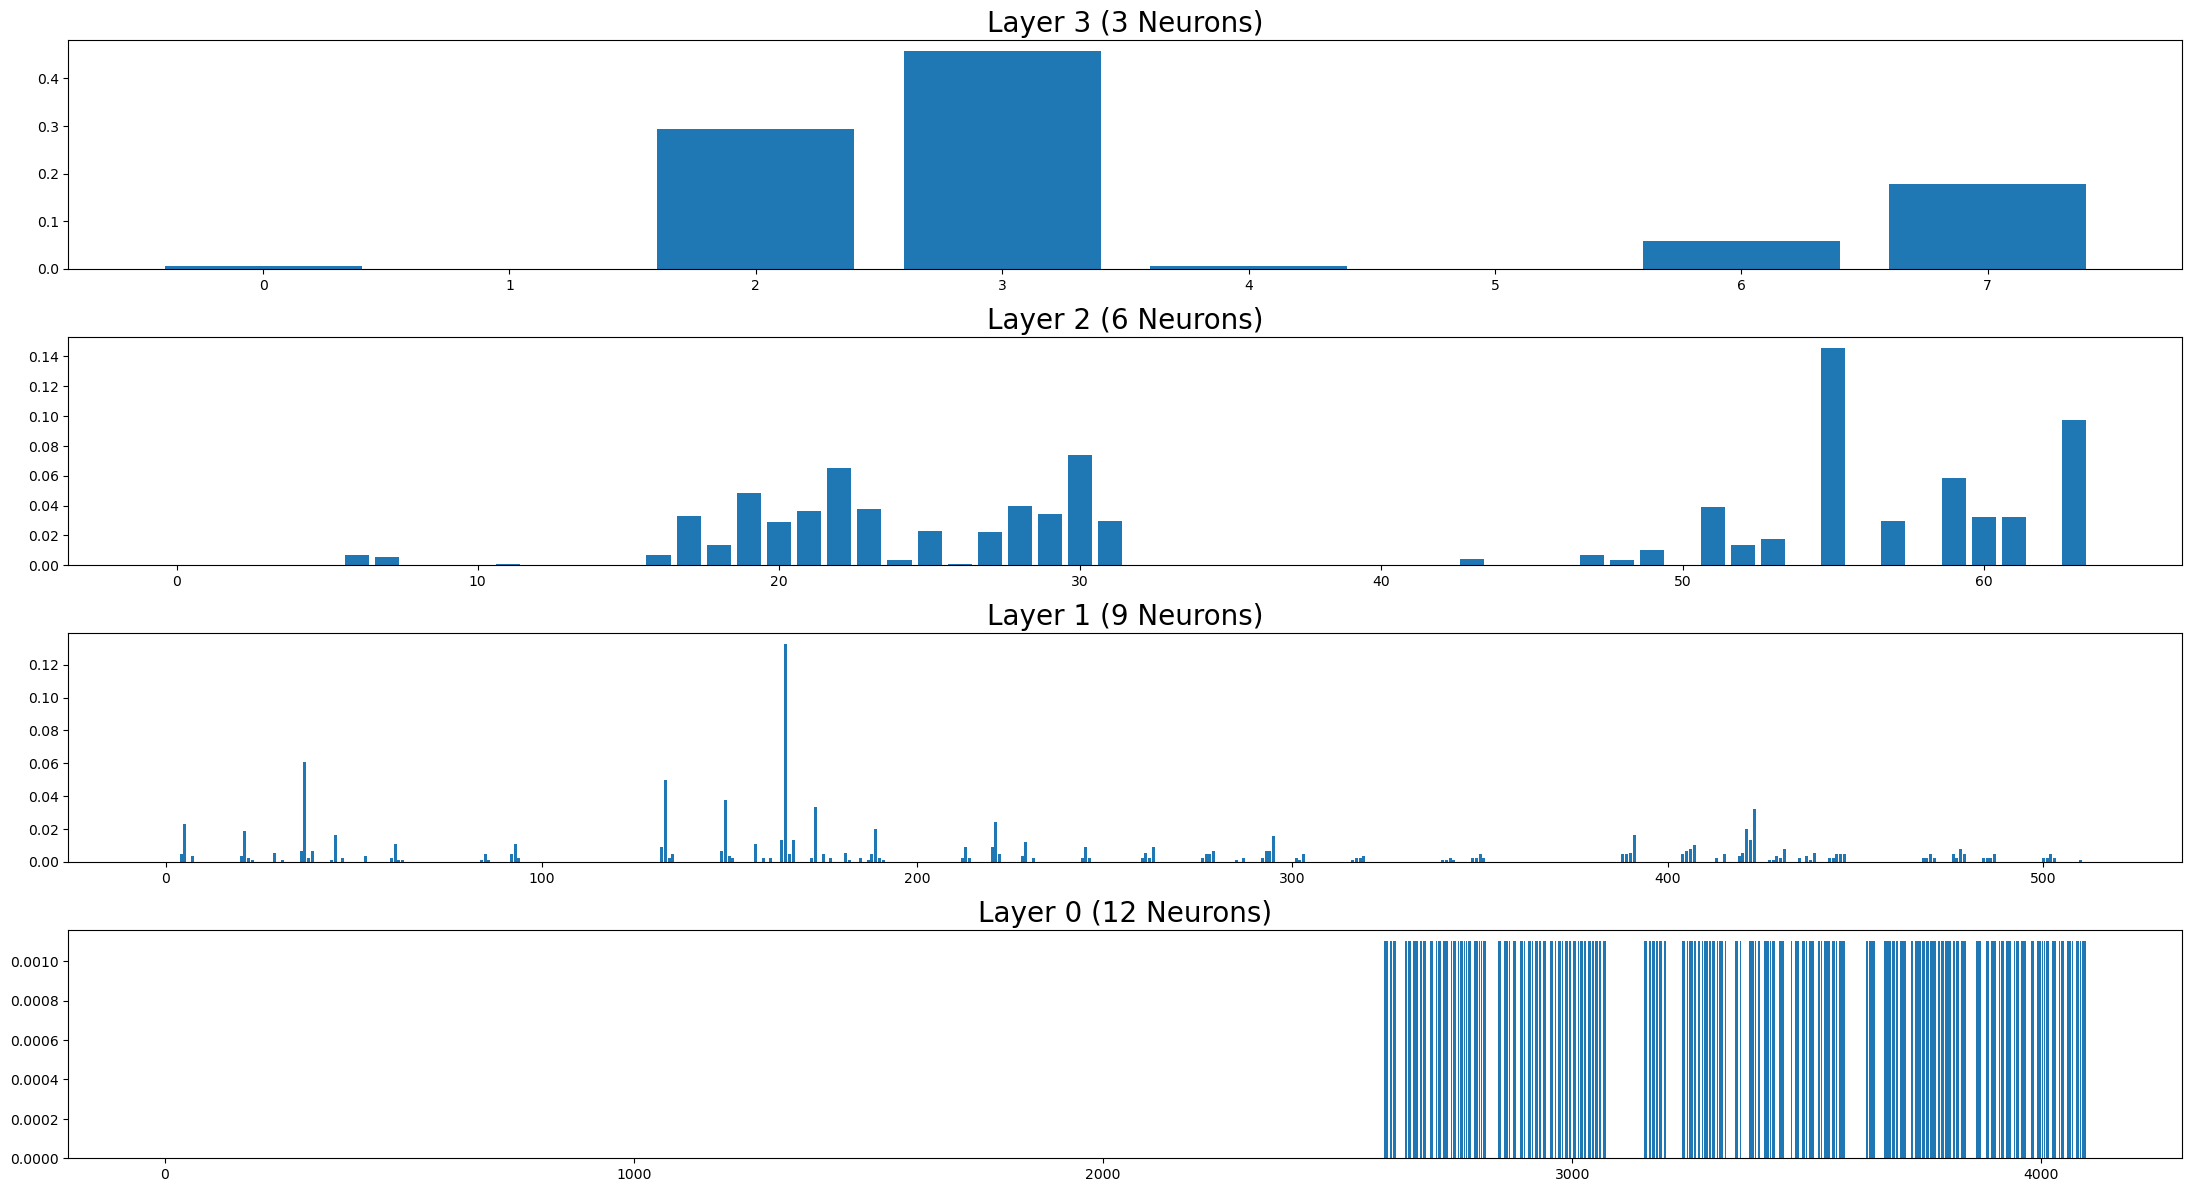

In [190]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
for i in range(n_layer-1):
    smp = scheduled_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist = torch.zeros(2**smp.shape[0],device=dev)
    dist[values_g]=counts_g/smp.shape[1]
    
    ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i]),dist.to('cpu').numpy(), label = 'Layer_'+str(i))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

In [191]:
lr = 0.1
epoch = 100000
batch_size = n_data
gen_batch_size = 100000
num = 1

In [197]:
for e in range(epoch):
#     scheduled_wake,H,h = wake_sample(Phi_HM,data,dev)
    Phi, Loss_wake = wake_phase_fixed(Phi,scheduled_sample,lr,dev)
    Theta, Loss_sleep = sleep_phase_fixed(Theta,scheduled_sample,lr,dev)
    if e%1000 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        gen_data = Gen_sample["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)
        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())

#         k = 0
#         for i in range(gen_batch_size):
#             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#                 k += 1
#         stat.append(k/gen_batch_size)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_MHM_layer2.loc[len(Analytic_MHM_layer2)] = stat

Loss_wake: tensor([0.0000, 0.0044, 0.0095, 0.0008])     Loss_sleep: tensor([0.2401, 0.1616, 0.3379, 0.4250])
Loss_wake: tensor([0.0000, 0.0044, 0.0095, 0.0008])     Loss_sleep: tensor([0.2401, 0.1616, 0.3379, 0.4250])
Loss_wake: tensor([0.0000, 0.0043, 0.0095, 0.0008])     Loss_sleep: tensor([0.2400, 0.1615, 0.3378, 0.4250])
Loss_wake: tensor([0.0000, 0.0043, 0.0094, 0.0008])     Loss_sleep: tensor([0.2400, 0.1615, 0.3378, 0.4250])
Loss_wake: tensor([0.0000, 0.0043, 0.0094, 0.0008])     Loss_sleep: tensor([0.2400, 0.1615, 0.3378, 0.4250])
Loss_wake: tensor([0.0000, 0.0042, 0.0094, 0.0008])     Loss_sleep: tensor([0.2400, 0.1615, 0.3378, 0.4250])
Loss_wake: tensor([0.0000, 0.0042, 0.0093, 0.0008])     Loss_sleep: tensor([0.2399, 0.1615, 0.3377, 0.4250])
Loss_wake: tensor([0.0000, 0.0042, 0.0093, 0.0008])     Loss_sleep: tensor([0.2399, 0.1614, 0.3377, 0.4250])
Loss_wake: tensor([0.0000, 0.0041, 0.0093, 0.0008])     Loss_sleep: tensor([0.2399, 0.1614, 0.3377, 0.4250])
Loss_wake: tensor([

Loss_wake: tensor([0.0000, 0.0027, 0.0073, 0.0004])     Loss_sleep: tensor([0.2388, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0027, 0.0073, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0027, 0.0072, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0027, 0.0072, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0027, 0.0072, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0027, 0.0072, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0026, 0.0072, 0.0004])     Loss_sleep: tensor([0.2387, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0026, 0.0072, 0.0004])     Loss_sleep: tensor([0.2390, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([0.0000, 0.0026, 0.0072, 0.0004])     Loss_sleep: tensor([0.2389, 0.1605, 0.3369, 0.4250])
Loss_wake: tensor([

In [193]:
epoch = 100
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    if e%1 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        gen_data = Gen_sample["Layer_0"]
        gen_dcm = decimalize(gen_data,dev)
        values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
        gen_dist = torch.zeros(2**n_d,device=dev)
        gen_dist[values_g]=counts_g/gen_batch_size

        stat.append(KL_divergence(gen_dist,data_dist).item())
        stat.append(KL_divergence(data_dist,gen_dist).item())

#         k = 0
#         for i in range(gen_batch_size):
#             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#                 k += 1
#         stat.append(k/gen_batch_size)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_MHM_layer1.loc[len(Analytic_MHM_layer1)] = stat

In [199]:
epoch = 1000
Epsilon = torch.ones(n_layer-2)*lr

In [283]:
# for e in range(epoch):
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
#     Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data_permute,lr,Epsilon,dev)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        
#     if e%10 == 0:
#         print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())

#         Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
#         Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

#         gen_data = Gen_sample["Layer_0"]
#         gen_dcm = decimalize(gen_data,dev)
#         values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
#         gen_dist = torch.zeros(2**n_d,device=dev)
#         gen_dist[values_g]=counts_g/gen_batch_size

#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())

# #         k = 0
# #         for i in range(gen_batch_size):
# #             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
# #                 k += 1
# #         stat.append(k/gen_batch_size)

#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
#         Analytic_MHM_layer1.loc[len(Analytic_MHM_layer1)] = stat

In [675]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'Parameters_MHM_Layer2_MI_acc')

In [202]:
gen_batch_size = 100000
Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

Layer 0 Data_dist D_KL: 0.3914
Layer 0 Gen_dist D_KL: 0.168
Layer 1 Recognition Distribution D_KL: 0.2196 H(Y): 4.7887 H(Y|X): 0.2048 I_XY: 4.5839
Layer 1 Generative  Distribution D_KL: 0.1157 H(Y): 4.7614 H(Y|X): 1.6962 I_XY: 4.2714
Layer 2 Recognition Distribution D_KL: 0.0998 H(Y): 3.224 H(Y|X): 0.437 I_XY: 2.787
Layer 2 Generative  Distribution D_KL: 0.0735 H(Y): 3.2409 H(Y|X): 2.4153 I_XY: 3.0652
Layer 3 Recognition Distribution D_KL: 0.0607 H(Y): 1.0849 H(Y|X): 0.2763 I_XY: 0.8086
Layer 3 Generative  Distribution D_KL: 0.0131 H(Y): 1.0969 H(Y|X): 1.0969 I_XY: 0.8256


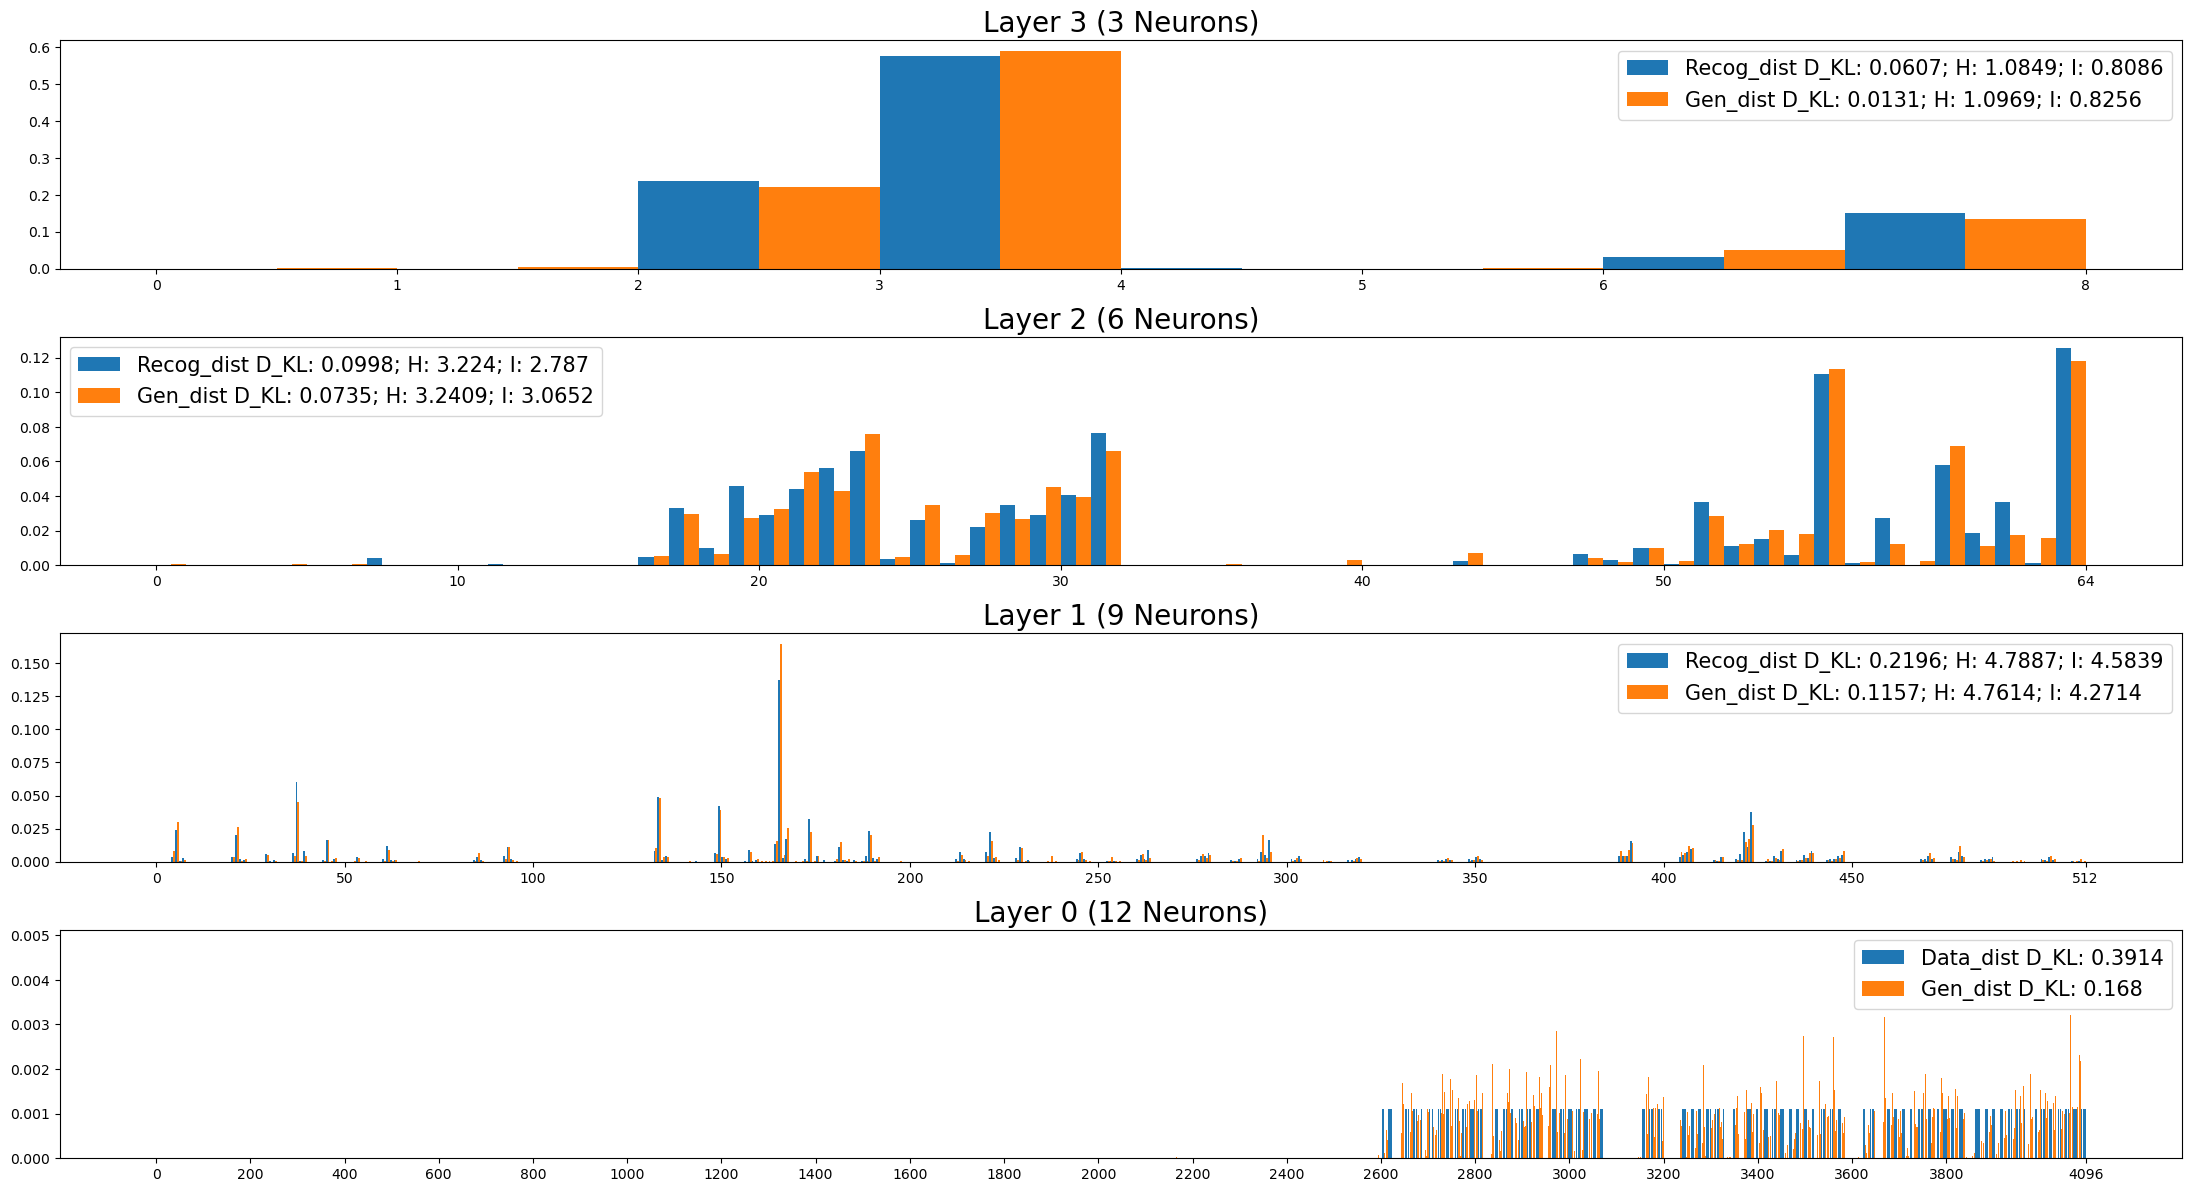

In [203]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
H_Y_wake = H_Y_wake.to('cpu').numpy()
H_YX_wake = H_YX_wake.to('cpu').numpy()
I_wake = H_Y_wake - H_YX_wake
H_Y_sleep = H_Y_sleep.to('cpu').numpy()
H_YX_sleep = H_YX_sleep.to('cpu').numpy()
I_sleep = H_Y_sleep - H_YX_sleep

for i in range(n_layer-1):
    smp = Recog_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist_w = torch.zeros(2**smp.shape[0],device=dev)
    dist_w[values_g]=counts_g/smp.shape[1]
    
    smp = Gen_sample['Layer_'+str(i)]
    values_g,counts_g = torch.unique(decimalize(smp,dev),return_counts=True)
    dist_s = torch.zeros(2**smp.shape[0],device=dev)
    dist_s[values_g]=counts_g/smp.shape[1]
    
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[0,n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)

plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 0.0029
Layer 0 Gen_dist D_KL: 0.0026
Layer 1 Recognition Distribution D_KL: 0.0049 H(Y): 4.8976 H(Y|X): 0.1195 I_XY: 4.778
Layer 1 Generative  Distribution D_KL: 0.0046 H(Y): 4.8923 H(Y|X): 1.5688 I_XY: 4.3394
Layer 2 Recognition Distribution D_KL: 0.0011 H(Y): 3.3511 H(Y|X): 0.1161 I_XY: 3.235
Layer 2 Generative  Distribution D_KL: 0.0011 H(Y): 3.3587 H(Y|X): 2.2004 I_XY: 3.3236
Layer 3 Recognition Distribution D_KL: 0.0003 H(Y): 1.271 H(Y|X): 0.0205 I_XY: 1.2504
Layer 3 Generative  Distribution D_KL: 0.0003 H(Y): 1.2793 H(Y|X): 1.2793 I_XY: 1.1583


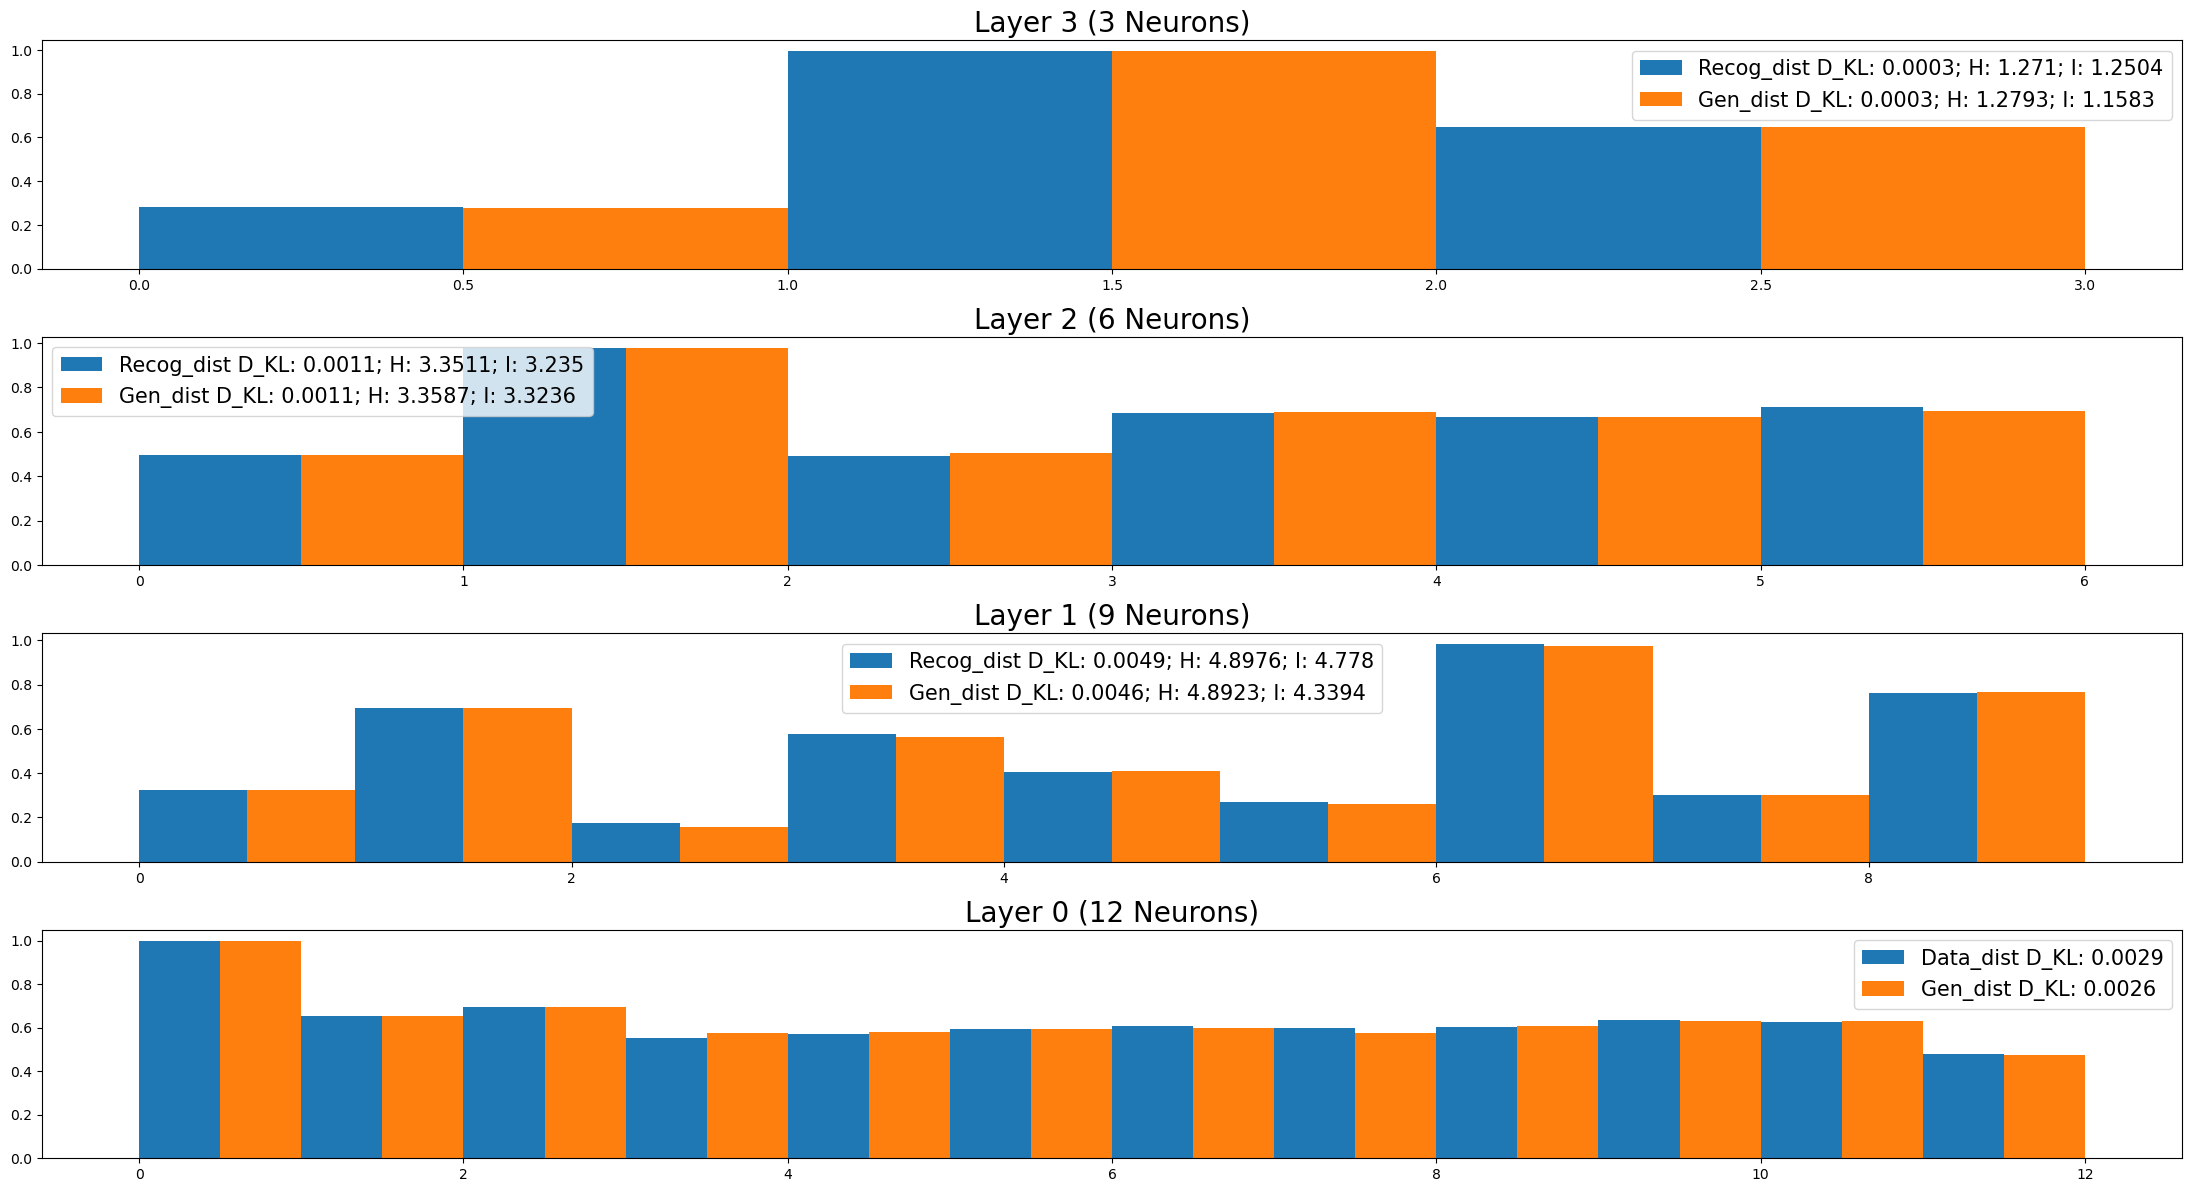

In [273]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))

for i in range(n_layer-1):
    dist_w = Recog_sample['Layer_'+str(i)].float().mean(axis=1)
    dist_s = Gen_sample['Layer_'+str(i)].float().mean(axis=1)
    D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
    D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

In [93]:
Analytic_MHM_layer2

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Recog_H_Layer_1,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3
0,2.509501,1.214835,0.850113,2.010575,1.858397,0.769126,0.631887,6.475070,12.428635,0.582518,...,-4.768372e-07,-8.344650e-07,0.000004,0.582967,1.454207,2.568568,1.914430,0.000004,0.000124,0.000983
1,0.548129,0.571453,0.450684,0.609210,0.540092,0.570331,0.451984,3.554741,0.530448,4.933176,...,0.000000e+00,2.908707e-05,0.000057,7.341159,4.910152,3.433532,1.359893,0.000295,0.001348,0.000112
2,0.548127,0.569847,0.449840,0.562180,0.408058,0.481915,0.451975,3.265656,0.515004,4.933167,...,0.000000e+00,1.249313e-04,0.000074,7.334883,4.885660,3.443433,1.356061,0.243186,0.699242,0.299402
3,0.548125,0.526273,0.445406,0.501058,0.346061,0.456157,0.451975,2.353578,0.398404,4.933159,...,4.768372e-07,6.062770e-02,0.000297,7.341830,4.929716,3.445010,1.355931,0.988879,1.413732,0.635947
4,0.548123,0.469688,0.336329,0.451646,0.290182,0.414582,0.451975,2.095922,0.348931,4.933148,...,0.000000e+00,4.339316e-01,0.123574,7.336000,4.869464,3.436255,1.355931,1.425709,1.668816,0.779096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.001024,0.000753,0.001850,0.237559,0.155757,0.353406,0.451975,0.483720,0.255778,4.933423,...,4.887208e+00,3.406271e+00,1.345801,7.329902,4.899076,3.394391,1.355931,4.431298,3.478583,1.269383
296,0.001018,0.000750,0.001849,0.237596,0.155750,0.353406,0.451975,0.485016,0.253997,4.933423,...,4.887411e+00,3.406288e+00,1.345152,7.316577,4.893303,3.395127,1.355931,4.398820,3.478579,1.276970
297,0.001012,0.000747,0.001849,0.236847,0.155743,0.353406,0.451975,0.498154,0.251883,4.933423,...,4.887612e+00,3.406816e+00,1.346474,7.339875,4.900001,3.395858,1.355931,4.444277,3.480372,1.268803
298,0.001006,0.000744,0.001848,0.237145,0.155736,0.353405,0.451975,0.469232,0.245893,4.933423,...,4.887814e+00,3.406787e+00,1.345819,7.317302,4.896028,3.393826,1.355931,4.396143,3.479310,1.271407


In [148]:
Analytic_MHM_layer2.to_csv('Analytic_MHM_layer2.csv', index = False)

In [147]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_MHM_layer2')

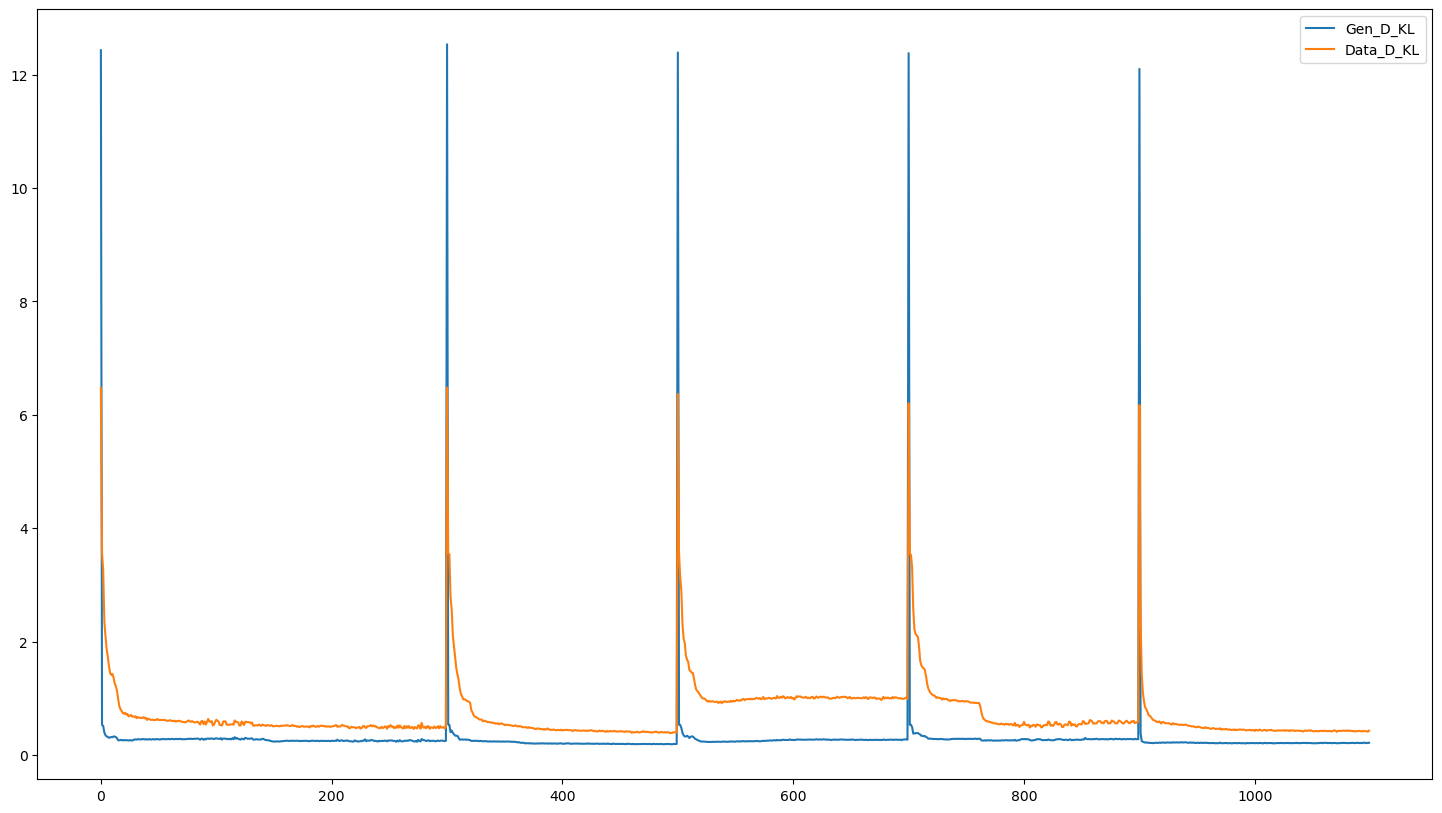

In [200]:
Analytic = Analytic_MHM_layer2
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

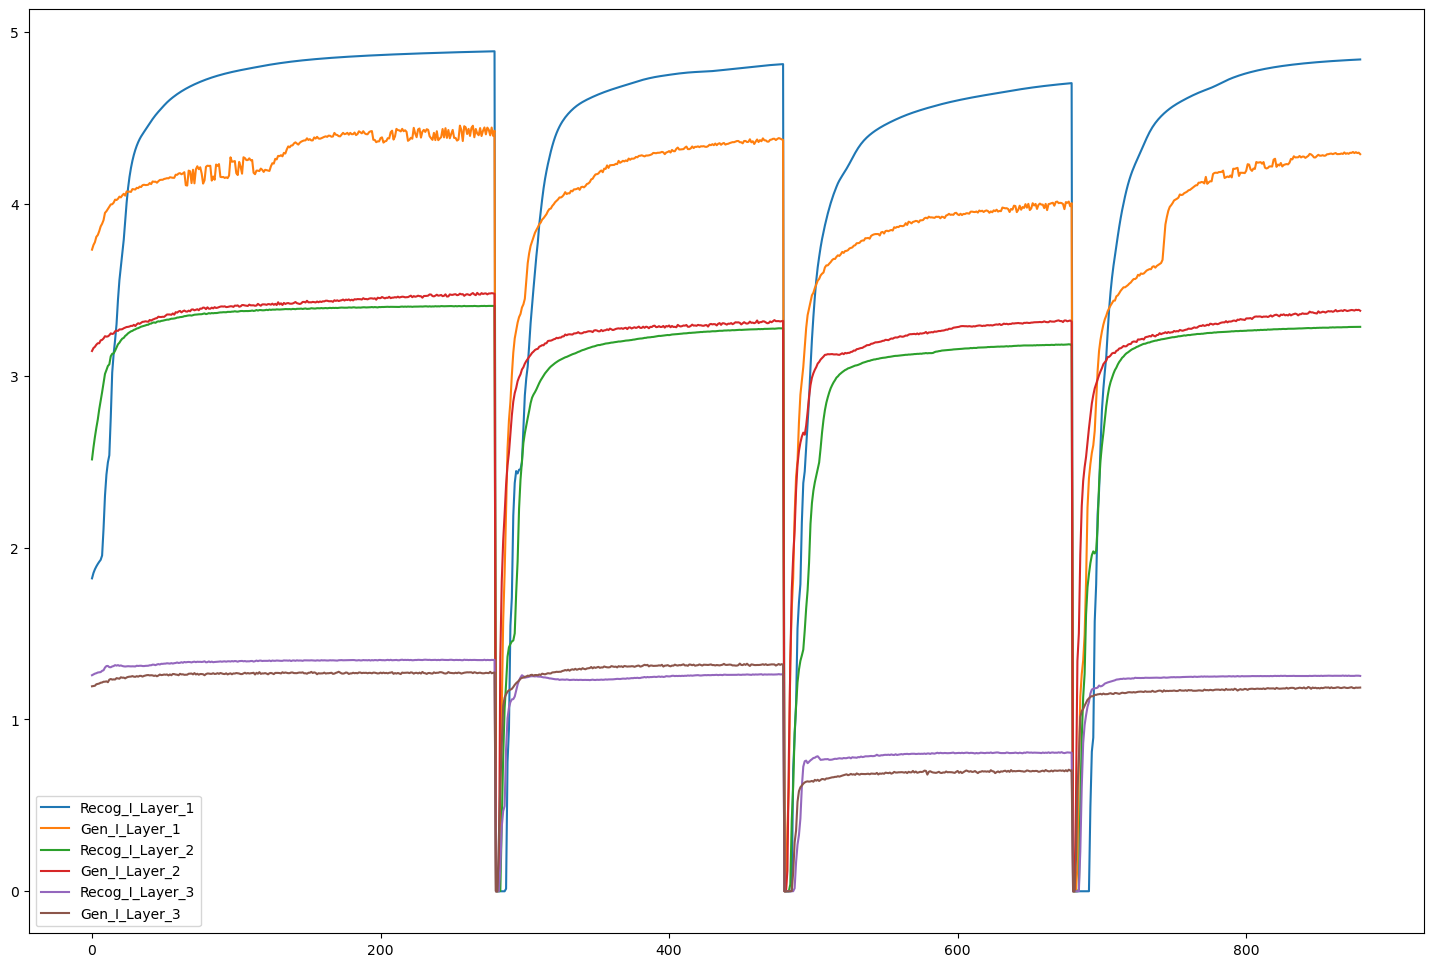

In [168]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)])[20:],label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)])[20:],label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

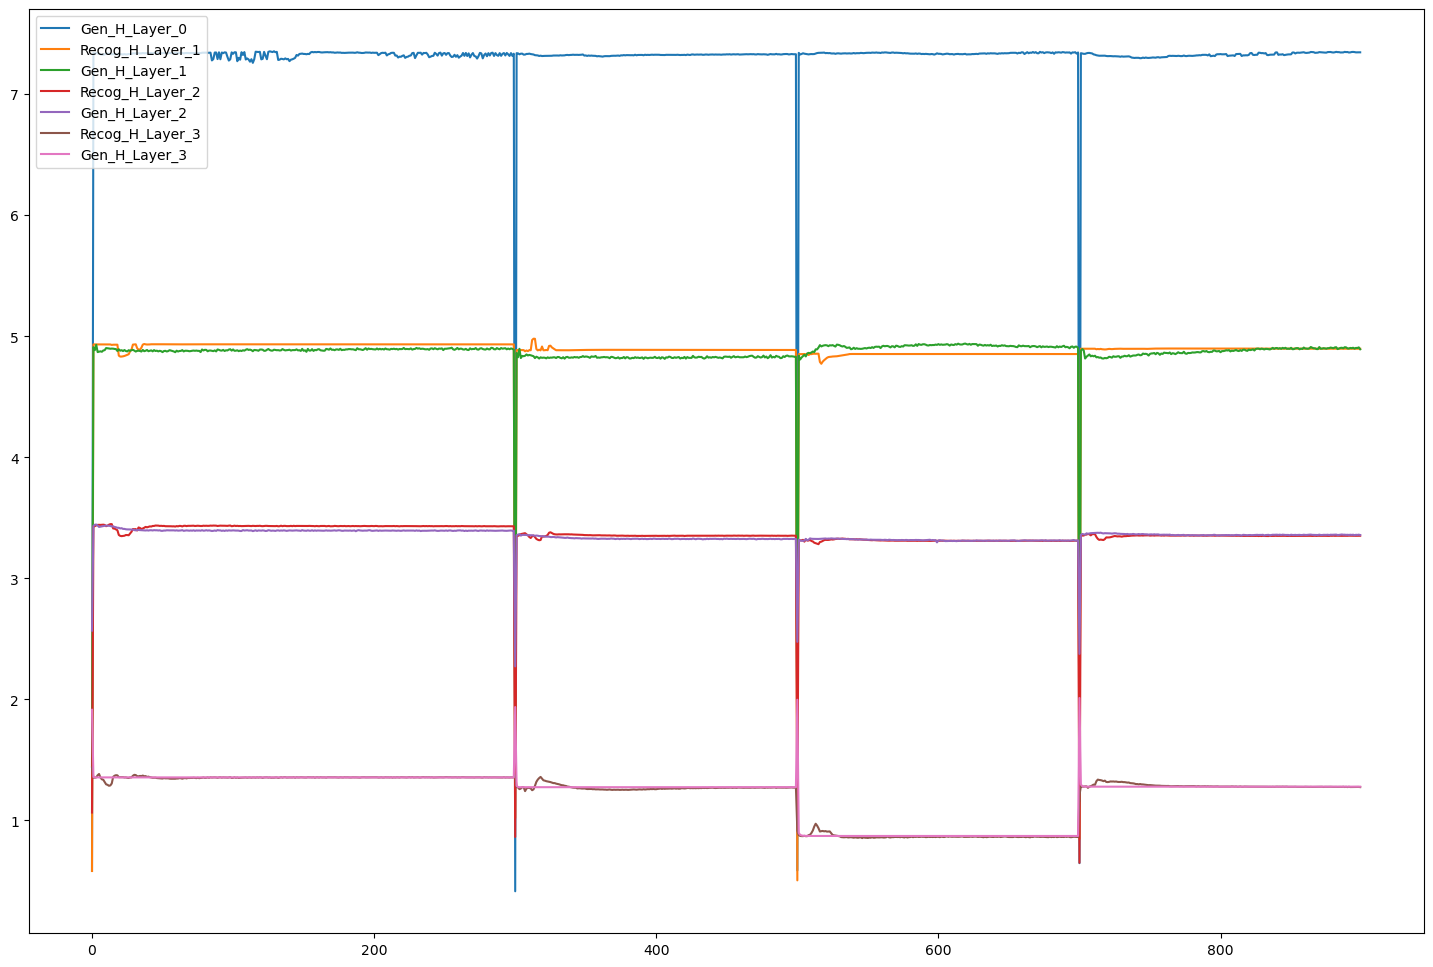

In [169]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [170]:
n_dz[:-1] * np.log(2)

tensor([[8.3178, 6.2383, 4.1589, 2.0794, 0.6931],
        [7.6246, 5.5452, 3.4657, 1.3863, 0.0000]])

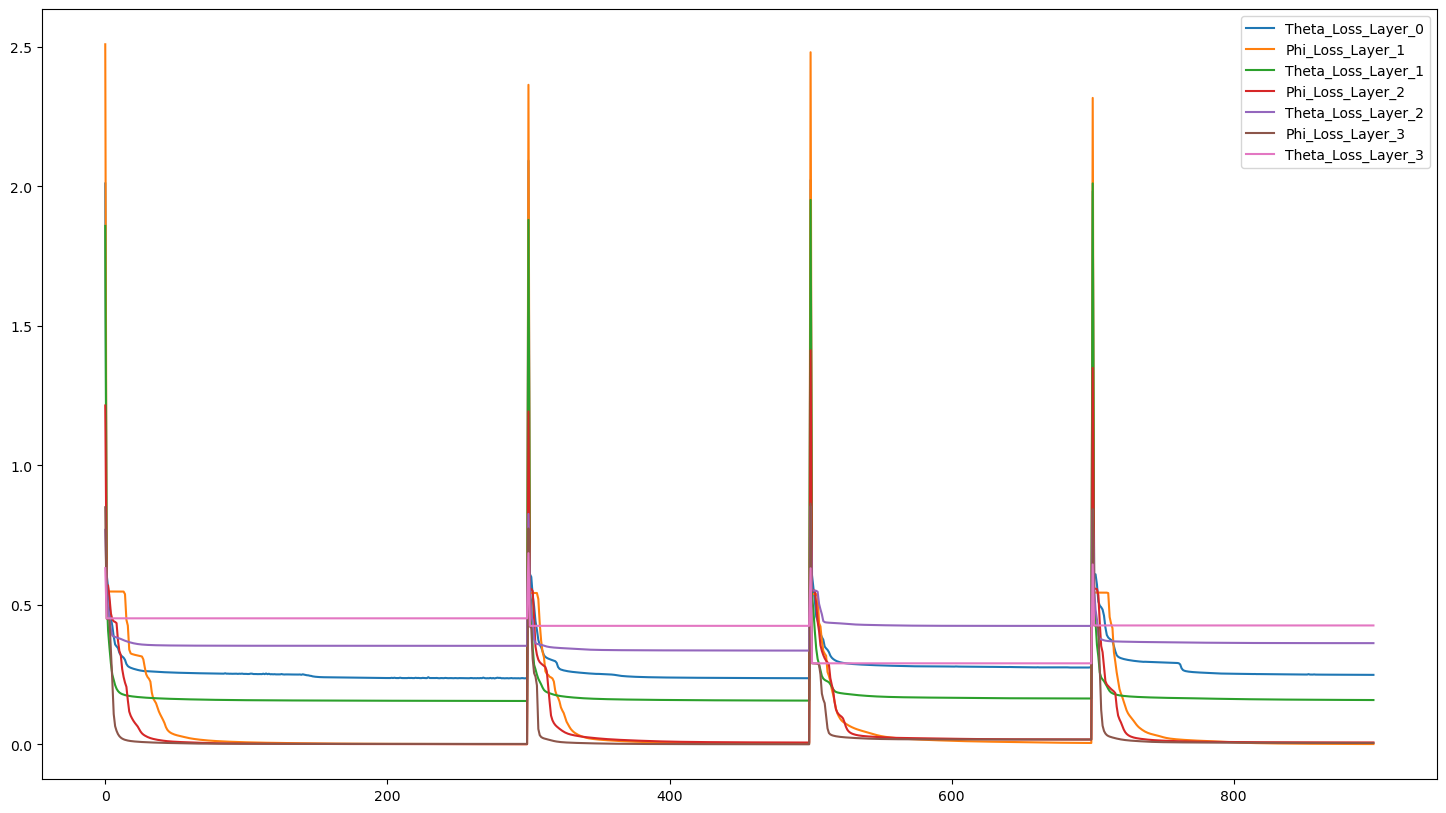

In [171]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()